In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
#seeding for comparing experiment in part 2
import torch
import json
SEED = 2017
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:6')

# SNLI Bert
## Second Tutorial
https://towardsdatascience.com/fine-tuning-pre-trained-transformer-models-for-sentence-entailment-d87caf9ec9db
Check his Github code for complete notebook. I never referred to it. Medium was enough.
BERT in keras-tf: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

In [39]:
# define macros
BERT_MODEL = 'GroNLP/bert-base-dutch-cased'
batch_size = 8
batches_per_epoch = None

save_path_suffix = 'labelweighingfeatureless_nld_1_'

# Prepare data

## load the dataset

In [40]:
import pandas as pd

# custom reader needed to handle quotechars
def read_df_custom(file):
    header = 'doc     unit1_toks      unit2_toks      unit1_txt       unit2_txt       s1_toks s2_toks unit1_sent      unit2_sent      dir     nuc_children    sat_children    genre   u1_discontinuous        u2_discontinuous       u1_issent        u2_issent       u1_length       u2_length       length_ratio    u1_speaker      u2_speaker      same_speaker    u1_func u1_pos  u1_depdir       u2_func u2_pos  u2_depdir       doclen  u1_position      u2_position     percent_distance        distance        lex_overlap_words       lex_overlap_length      unit1_case      unit2_case      label'
    extracted_columns = ['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label', 'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case', 'unit2_case',
                            'u1_discontinuous', 'u2_discontinuous', 'same_speaker', 'lex_overlap_length', 'u1_func']
    header = header.split()
    df = pd.DataFrame(columns=extracted_columns)
    file = open(file, 'r')

    rows = []
    count = 0 
    for line in file:
        line = line[:-1].split('\t')
        count+=1
        if count ==1: continue
        row = {}
        for column in extracted_columns:
            index = header.index(column)
            try:
                row[column] = line[index]
            except:
                print(count, line)
            row[column] = line[index]
        rows.append(row)

    df = pd.concat([df, pd.DataFrame.from_records(rows)])
    return df

train_df = read_df_custom('../../processed/nld.rst.nldt_train_enriched.rels')
test_df = read_df_custom('../../processed/nld.rst.nldt_test_enriched.rels')
val_df = read_df_custom('../../processed/nld.rst.nldt_dev_enriched.rels')

lang='deu'

In [41]:
def get_batches_per_epoch(train_df, batch_size=4):
    size = len(train_df)
    if size%batch_size!=0:
        return int(size/batch_size)+1
    else:
        return int(size/batch_size)

batches_per_epoch = get_batches_per_epoch(train_df, batch_size)
print(batches_per_epoch*batch_size, len(train_df), batches_per_epoch)

1608 1608 201


## Clean the data

In [42]:
#dropping any empty values
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## Prepare a dataset handler class

In [43]:
train_df.head()

,unit1_txt,unit1_sent,unit2_txt,unit2_sent,dir,label,distance,u1_depdir,u2_depdir,u2_func,...,sat_children,nuc_children,genre,unit1_case,unit2_case,u1_discontinuous,u2_discontinuous,same_speaker,lex_overlap_length,u1_func
0,Verleidelijk is het wel .,Verleidelijk is het wel .,De gedachte om van alle modellen één paar acht...,De gedachte om van alle modellen één paar acht...,1>2,preparation,1,ROOT,ROOT,root,...,0,3,AD,title,cap_initial,False,False,True,0,root
1,De gedachte om van alle modellen één paar acht...,De gedachte om van alle modellen één paar acht...,Maar ergens is er toch een bepaald zakelijk in...,Maar ergens is er toch een bepaald zakelijk in...,1>2,concession,3,ROOT,ROOT,root,...,3,2,AD,cap_initial,cap_initial,False,False,True,0,root
2,De gedachte om van alle modellen één paar acht...,De gedachte om van alle modellen één paar acht...,Om bijvoorbeeld later een bescheiden schoenmus...,Om bijvoorbeeld later een bescheiden schoenmus...,1<2,purpose,1,ROOT,ROOT,root,...,0,3,AD,cap_initial,cap_initial,False,False,True,0,root
3,De gedachte om van alle modellen één paar acht...,De gedachte om van alle modellen één paar acht...,Ook fijn : elke week een vers paar schoenen ui...,Ook fijn : elke week een vers paar schoenen ui...,1<2,conjunction,2,ROOT,ROOT,root,...,0,3,AD,cap_initial,cap_initial,False,False,True,1,root
4,Maar ergens is er toch een bepaald zakelijk in...,Maar ergens is er toch een bepaald zakelijk in...,Gelukkig kan ik wel elke dag naar schoenen kij...,Gelukkig kan ik wel elke dag naar schoenen kij...,1>2,concession,2,ROOT,ROOT,root,...,2,2,AD,cap_initial,cap_initial,False,False,True,0,root


In [44]:
train_df.columns

Index(['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label',
       'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position',
       'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case',
       'unit2_case', 'u1_discontinuous', 'u2_discontinuous', 'same_speaker',
       'lex_overlap_length', 'u1_func'],
      dtype='object')

# feats

In [45]:
from multiprocessing.sharedctypes import Value
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
from sys import path
path.append('/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/allennlp/data/data_loaders/')
from allennlp.data import allennlp_collate, Vocabulary
from features_custom_original import get_vocab_feature_name
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertTokenizer

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df, test_df):
    self.lang = lang
    self.num_labels = set()
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.train_idx = None
    self.val_idx = None
    self.test_idx = None
    self.vocab = Vocabulary(counter=None, max_vocab_size=100000)
    self.init_data()

  def init_data(self):
    self.get_label_mapping()
    self.init_feature_list()
    self.init_feature_mappings_and_bins()
    self.apply_bins()
    self.calculate_unique_values()
    self.train_data, self.train_idx = self.load_data(self.train_df)
    self.val_data, self.val_idx = self.load_data(self.val_df)
    self.test_data, self.test_idx = self.load_data(self.test_df)
    

  def combine_unique_column_values_to_dict(self, column_name):
    ini_set = set([*self.train_df[column_name].unique(), *self.val_df[column_name].unique()])
    res = dict.fromkeys(ini_set, 0)
    return res

  def get_label_mapping(self):
    labels = {}
    labels_list = list(set(list(self.train_df['label'].unique()) + list(self.test_df['label'].unique()) + list(self.val_df['label'].unique())))
    for i in range(len(labels_list)):
        labels[labels_list[i]] = i
    self.label_dict = labels
    # needed later for classification report object to generate precision and recall on test dataset
    self.rev_label_dict = {self.label_dict[k]:k for k in self.label_dict.keys()} 

  def init_feature_mappings_and_bins(self):
    self.feature_maps = { 'genre': self.combine_unique_column_values_to_dict('genre'),
                          'unit1_case': self.combine_unique_column_values_to_dict('unit1_case'),
                          'unit2_case': self.combine_unique_column_values_to_dict('unit2_case'),
                          'u1_func': self.combine_unique_column_values_to_dict('u1_func'),
                          'u2_func': self.combine_unique_column_values_to_dict('u2_func') }

    self.bins = {
      'distance': [[-1e9, -8], [-8, -2], [-2, 0], [0, 2], [2, 8], [8, 1e9]],
      'u1_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'u2_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'lex_overlap_length': [[0, 2], [2, 7], [7, 1e9]]
    }   

  def add_directionality(self, premise, hypothesis, dir):
    if dir == "1<2":
        hypothesis = '< ' + hypothesis + ' {'
    else:
        premise = '} ' + premise + ' >'
    return premise, hypothesis

  def init_feature_list(self):
    if self.lang=='nld':
      self.feature_list = ['distance', 'u1_depdir', 'sat_children', 'genre', 'u1_position']
    elif self.lang=='deu':
      self.feature_list = ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children']
    elif self.lang=='eng.rst.gum':
      self.feature_list = ['distance', 'same_speaker', 'u2_func', 'u2_depdir', 'unit1_case', 'unit2_case', 'nuc_children',
                      'sat_children', 'genre', 'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'u1_position', 'u2_position']
    elif self.lang=='fas':
      self.feature_list = ['distance', 'nuc_children', 'sat_children', 'u2_discontinuous', 'genre']
    elif self.lang=='spa.rst.sctb':
      self.feature_list = ['distance', 'u1_position', 'sat_children']
    elif self.lang=='zho.rst.sctb':
      self.feature_list = ['sat_children', 'nuc_children', 'genre', 'u2_discontinuous', 'u1_discontinuous', 'u1_depdir', 'u1_func']
    else: 
      raise ValueError()

  def get_mapping_from_dictionary(self, column_name, dict_val):
    return self.feature_maps[column_name][dict_val]

  def get_allen_features_list(self, features, feature_name):
    if feature_name in ['distance', 'u1_depdir', 'u2_depdir', 'u1_func', 'u2_func', 
    'u1_position', 'u2_position', 'genre', 'same_speaker', 'unit1_case', 'unit2_case',
    'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'dir']: feature_value = self.apply_vocab(features[feature_name], feature_name) #for categorical values
    elif feature_name in ['sat_children', 'nuc_children']: feature_value = float(features[feature_name]) #for identiy values
    else: 
      print(feature_name)
      raise ValueError()
    return feature_value

  def transform_feature(self, features):
    assert len(features)==17
    #after applying the vocab. we need to pass them as int
    return {feature_name: torch.tensor(int(self.get_allen_features_list(features, feature_name))).to(device) for feature_name in self.feature_list+['dir']}

  def calculate_unique_values(self):
    for feature_name in self.feature_list+['dir']:
      vocab_feature_name = get_vocab_feature_name(feature_name)
      self.vocab.add_tokens_to_namespace(train_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)
      self.vocab.add_tokens_to_namespace(val_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)

  def apply_bins(self):
    for df in [self.train_df, self.test_df, self.val_df]:
      for feature_name in self.bins.keys():
        if feature_name=='u2_func':
          print(df[feature_name].unique())
          raise ValueError()
        df[feature_name] = df[feature_name].apply(lambda x: self.get_mapping_from_bin(feature_name, float(x)))

  def get_mapping_from_bin(self, column_name, dict_val):
    bins = self.bins[column_name]
    for b,i in zip(bins, range(len(bins))):
      left = b[0]
      right = b[1]
      if left<=dict_val and right>=dict_val: return i

  def apply_vocab(self, feature_value, feature_name):
    return self.vocab.get_token_index(str(feature_value), namespace=get_vocab_feature_name(feature_name))

  def set_labels(self):
    self.num_labels = len(self.num_labels)
    
  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    # seg_ids = []
    y = []
    feats = []
    idx = []
    idx_map = {}

    self.num_labels.update(df['label'].unique())

    count=0
    for row in df.iterrows():
      row = row[1]
      premise = row['unit1_txt']
      hypothesis = row['unit2_txt']
      label = row['label']
      dir = row['dir']

      features = {'distance': row['distance'],
                'u1_depdir': row['u1_depdir'],
                'u2_depdir': row['u2_depdir'],
                'u1_func': row['u1_func'],
                'u2_func': row['u2_func'],
                'u1_position': row['u1_position'],
                'u2_position': row['u2_position'],
                'sat_children': row['sat_children'],
                'nuc_children': row['nuc_children'],
                'genre': row['genre'],
                'unit1_case': row['unit1_case'],
                'unit2_case': row['unit2_case'],
                'u1_discontinuous': row['u1_discontinuous'],
                'u2_discontinuous': row['u2_discontinuous'],
                'same_speaker': row['same_speaker'],
                'lex_overlap_length': row['lex_overlap_length'],
                'dir': row['dir']}

      premise, hypothesis = self.add_directionality(premise, hypothesis, dir)
      encoded = self.tokenizer.encode_plus(premise, hypothesis, add_special_tokens = True, max_length=MAX_LEN, truncation=True, padding=False) #padding='max_length'
      pair_token_ids = torch.tensor(encoded['input_ids'])

      # segment_ids = torch.tensor(encoded['token_type_ids'])
      attention_mask_ids = torch.tensor(encoded['attention_mask'])
      assert len(pair_token_ids)==len(attention_mask_ids)

      features = self.transform_feature(features)

      token_ids.append(pair_token_ids)
      # seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
      feats.append(features)
      
      idx_map[count] = [premise, hypothesis]
      idx.append(count)
      count+=1
      
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    # seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    idx = torch.tensor(idx)

    class featureDataset(Dataset):
      def __init__(self, token_ids, mask_ids, feats, y, idx):
          self.token_ids = token_ids
          self.mask_ids = mask_ids
          # self.seg_ids = seg_ids
          self.feats = feats
          self.y = y
          self.idx = idx

      def __len__(self):
          return len(self.feats)

      def __getitem__(self, idx):
          return self.token_ids[idx], self.mask_ids[idx], self.feats[idx], self.y[idx], self.idx[idx]
          # return self.token_ids[idx], self.mask_ids[idx], self.seg_ids[idx], self.feats[idx], self.y[idx], self.idx[idx]

    # dataset = featureDataset(token_ids, mask_ids, seg_ids, feats, y, idx)
    dataset = featureDataset(token_ids, mask_ids, feats, y, idx)
    return dataset, idx_map

  def get_data_loaders(self, batch_size=4, batches_per_epoch=402, shuffle=True): #1609 samples / 64:25=1600 / 402:4=1608
    self.set_labels()
    train_loader_torch = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    val_loader_torch = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    test_loader_torch = DataLoader(
      self.test_data,
      shuffle=False,
      batch_size=batch_size,
    )
    
    train_loader = LoaderWrapper(train_loader_torch, n_step=batches_per_epoch)
    val_loader = LoaderWrapper(val_loader_torch, n_step=batches_per_epoch)
    test_loader = LoaderWrapper(test_loader_torch, n_step=batches_per_epoch)

    return train_loader, val_loader_torch, test_loader_torch

In [46]:
class LoaderWrapper:
    def __init__(self, loader, n_step):
        self.step = n_step
        self.idx = 0
        self.iter_loader = iter(loader)
        self.loader = loader
    
    def __iter__(self):
        return self

    def __len__(self):
        return self.step

    def __next__(self):
        # if reached number of steps desired, stop
        if self.idx == self.step:
            self.idx = 0
            raise StopIteration
        else:
            self.idx += 1
        # while True
        try:
            return next(self.iter_loader)
        except StopIteration:
            # reinstate iter_loader, then continue
            self.iter_loader = iter(self.loader)
            return next(self.iter_loader)

### Mnliloader

In [47]:
mnli_dataset = MNLIDataBert(train_df, val_df, test_df)

train_loader, val_loader, test_loader = mnli_dataset.get_data_loaders(batch_size=batch_size, batches_per_epoch=batches_per_epoch) #64X250
label_dict = mnli_dataset.label_dict # required by custom func to calculate accuracy, bert model
rev_label_dict = mnli_dataset.rev_label_dict # required by custom func to calculate accuracy

In [48]:
counts = val_df.groupby(['label']).count()['dir']

mnli_dataset.label_weights = []
for i in range(len(mnli_dataset.label_dict)):
    try:
        mnli_dataset.label_weights.append(counts[mnli_dataset.rev_label_dict[i]])
    except:
        mnli_dataset.label_weights.append(1)

mnli_dataset.label_weights = [float(x) for x in mnli_dataset.label_weights]
mnli_dataset.label_weights = torch.tensor(mnli_dataset.label_weights).to(device)

In [49]:
for feature in mnli_dataset.feature_list:
    vocab_feature_name = get_vocab_feature_name(feature)
    print(feature, ': ', mnli_dataset.vocab.get_token_to_index_vocabulary(vocab_feature_name))
print('dir', ': ', mnli_dataset.vocab.get_token_to_index_vocabulary('dir'))

distance :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '3': 2, '4': 3, '5': 4}
u1_depdir :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'RIGHT': 3, 'LEFT': 4}
u2_depdir :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'RIGHT': 3, 'LEFT': 4}
u2_func :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'root': 2, 'conj': 3, 'acl': 4, 'appos': 5, 'advcl': 6, 'nsubj': 7, 'nmod': 8, 'advmod': 9, 'amod': 10, 'obj': 11, 'flat': 12, 'acl:relcl': 13, 'obl': 14, 'parataxis': 15, 'xcomp': 16, 'det': 17, 'orphan': 18, 'nummod': 19, 'csubj': 20, 'obl:agent': 21, 'ccomp': 22, 'fixed': 23, 'punct': 24, 'mark': 25}
u1_position :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}
u2_position :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '0': 2, '1': 3, '2': 4, '5': 5, '3': 6, '4': 7, '8': 8, '6': 9, '7': 10, '9': 11}
sat_children :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '0': 2, '3': 3, '2': 4, '1': 5, '4': 6, '5': 7, '6': 8, '7': 9}
nuc_children :  {'@@P

In [50]:
max_i = -1
for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(val_loader):
    # print(max(idx).item())
    if max_i<max(idx).item(): max_i = max(idx).item()
    assert len(feat)==len(mnli_dataset.feature_list)+1
print(max_i)

330


# Define the model

## load pretrained model

In [51]:
from transformers import BertForSequenceClassification, AdamW
from torch import optim
import os
path.append(os.path.join(os.getcwd(), '../utils/'))
from CategoricalAccuracy import CategoricalAccuracy as CA
import numpy as np

ca = CA()

x = torch.tensor(np.array([[[1,0,0], [1,0,0], [1,0,0]]]))
y1 = torch.tensor(np.array([[0], [1], [1]]))
y2 = torch.tensor(np.array([[0], [0], [0]]))

ca(x,y1)
print(ca.get_metric(reset=True))
ca(x,y2)
print(ca.get_metric(reset=True))

0.3333333333333333
1.0


## define evaulation metric

In [52]:
# to evaluate model for train and test. And also use classification report for testing
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# helper function to calculate the batch accuracy
def multi_acc(y_pred, y_test, allennlp=False):
  if allennlp==False:
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

# freeze model weights and measure validation / test 
def evaluate_accuracy(model, optimizer, data_loader, rev_label_dict, label_dict, is_training=True):
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  
  #for classification report
  y_true = []
  y_pred = []
  idx_list = []
  premise_list = []
  hypo_list = []
  idx_map = mnli_dataset.val_idx if is_training else mnli_dataset.test_idx

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(data_loader):      
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      # seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      
      outputs = model(pair_token_ids, 
                            # token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            feat=feat)
      criterion = nn.CrossEntropyLoss(weight=mnli_dataset.label_weights)
      loss = criterion(outputs, labels)
      acc = multi_acc(outputs, labels)

      total_val_loss += loss.item()
      total_val_acc  += acc.item()

      # log predictions for classification report
      argmax_predictions = torch.argmax(outputs,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])
      for i in idx.tolist():
        idx_list.append(i)
        try:
          premise_list.append(idx_map[i][0])
        except:
          print(idx_map.keys())
          print(i)
        hypo_list.append(idx_map[i][1])

  val_acc  = total_val_acc/len(data_loader)
  val_loss = total_val_loss/len(data_loader)
  cr = classification_report(y_true, y_pred)

  idx_json = {'idx': idx_list, 'gold_label': y_true, 'pred_label': y_pred, 'premise': premise_list, 'hypothesis': hypo_list}
  
  return val_acc, val_loss, cr, model, optimizer, idx_json

## define custom bert model

In [53]:
import copy
from typing import Any, Dict, Optional
from transformers import BertModel, BertConfig
import torch.nn as nn
from tensorflow.keras.layers import TimeDistributed
from featurefulbertembedder_custom_allennlp_dims import FeaturefulBertEmbedder
from featureful_bert_custom_allennlp_dims import get_combined_feature_tensor_2 as get_combined_feature_tensor_forward
from features_custom_allennlp_dims import get_feature_modules

class CustomPooler2(nn.Module):
    def __init__(self, *,
                        requires_grad: bool = True,
                        dropout: float = 0.0,
                        transformer_kwargs: Optional[Dict[str, Any]] = None, ) -> None:
        super().__init__()
        bert = BertModel.from_pretrained(BERT_MODEL) #only used to pass config. BertAttentionClass used in FeatureFulBert
        self._dropout = torch.nn.Dropout(p=dropout)
        self.pooler = copy.deepcopy(bert.pooler)
        for param in self.pooler.parameters():
            param.requires_grad = requires_grad
        self._embedding_dim = bert.config.hidden_size

    def get_input_dim(self) -> int:
        return self._embedding_dim

    def get_output_dim(self) -> int:
        return self._embedding_dim

    def forward(self, tokens: torch.Tensor, mask: torch.BoolTensor = None, num_wrapping_dims: int = 0):
        pooler = self.pooler
        
        for _ in range(num_wrapping_dims):
            pooler = TimeDistributed(pooler)
        pooled = pooler(tokens)
        pooled = self._dropout(pooled)
        return pooled

class MyModule(nn.Module):    
    def __init__(self, feature_list):
        super(MyModule, self).__init__()
        self.feature_list = feature_list
        self.feature_modules = nn.ModuleDict()
        self.dims = 0
        self.feature_modules, dims = get_feature_modules(feature_list, mnli_dataset.vocab, use_allennlp_dims=True)
        self.dims += dims

        print(self.feature_modules)
        for feature in feature_list:
            if feature not in ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 
                                'nuc_children', 'sat_children']: raise ValueError()
            # elif 'genre' in feature_list:               self.modules['genre'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'unit1_case' in feature_list:          self.modules['unit1_case'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'unit2_case' in feature_list:          self.modules['unit2_case'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u1_discontinuous' in feature_list:    self.modules['u1_discontinuous'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u2_discontinuous' in feature_list:    self.modules['u2_discontinuous'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'same_speaker' in feature_list:        self.modules['same_speaker'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'lex_overlap_length' in feature_list:  self.modules['lex_overlap_length'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u1_func' in feature_list:             self.modules['u1_func'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)

    def forward(self, features):
        feature_list = ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children']
        for i in range(len(feature_list)):
            feature_name = feature_list[i]
            feature_modules = self.feature_modules[feature_name]
            feature = features[...,i]
            if feature_name not in ['sat_children', 'nuc_children']:
                if torch.max(feature)>feature_modules.num_embeddings:
                    print(feature_name, feature)
                    raise ValueError()

        return get_combined_feature_tensor_forward(features, self.feature_list, self.feature_modules)

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
          super(CustomBERTModel, self).__init__()
          self.num_classes = num_labels
          self.feature_list = mnli_dataset.feature_list
          print('ASSIGN:', self.num_classes)

          self.embedder = self.create_featureful_bert() #BERT MODEL
          self.encoder = CustomPooler2()
          self.module1 = MyModule(self.feature_list)
          self.dropout1 = nn.Dropout(p=0.0)
        #   self.dropout_decoder = nn.Dropout(p=0.5)
          self.out_features = self.encoder.pooler.dense.out_features#+self.module1.dims
          self.relation_decoder = nn.Linear(self.out_features, self.num_classes)

    def forward(self, pair_token_ids, attention_mask, feat):
        direction_tensor = feat['dir'].to(device)
        embedded_sentence = self.embedder(token_ids=pair_token_ids, #featurefulmebedder
                        mask=attention_mask, 
                        # type_ids=token_type_ids,
                        segment_concat_mask = None,
                        direction_tensor = direction_tensor,
                        feature_list = self.feature_list,
                        features = feat)
        # mask = token_type_ids
        bertpooler_output = self.encoder(tokens=embedded_sentence, mask=None)
        
        feat = self.convert_to_feature_list(feat)
        feat = self.dropout1(feat)
        feat = self.module1(feat)
        try:
            feat_concat = bertpooler_output#torch.concat((bertpooler_output, feat),-1)
        except:
            print(bertpooler_output.shape, feat.shape)
            raise ValueError()
        if feat_concat.shape[-1]!=bertpooler_output.shape[-1]: print(feat_concat.shape, self.module1.dims)
        assert feat_concat.shape[-1] == bertpooler_output.shape[-1]
        feat_concat = self.dropout1(feat_concat)

        linear1_output = self.relation_decoder(feat_concat)
        return linear1_output


    def create_featureful_bert(self):
        featureful_bert = FeaturefulBertEmbedder(model_name = BERT_MODEL,
                                hidden_activation_allen = 'gelu',
                                feature_list = self.feature_list, 
                                vocab=mnli_dataset.vocab,
                                use_allen_dims=True)
        return featureful_bert

    def convert_to_feature_list(self, feat):
        feature_linear = [feat[feature_name] for feature_name in self.feature_list]
        feature_linear = torch.stack(feature_linear, dim=-1)
        return feature_linear

model = CustomBERTModel(mnli_dataset.num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-6, correct_bias=False) # original 2e-5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, mode='max', patience=35, min_lr=5e-7, verbose=True) #original factor=0.6, min_lr=5e-7

ASSIGN: 33


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing FeaturefulBert: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing FeaturefulBert from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FeaturefulBert from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FeaturefulBert were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.

ModuleDict(
  (distance): Embedding(5, 3, padding_idx=0)
  (u1_depdir): Embedding(5, 3, padding_idx=0)
  (u2_depdir): Embedding(5, 3, padding_idx=0)
  (u2_func): Embedding(26, 6, padding_idx=0)
  (u1_position): Embedding(12, 4, padding_idx=0)
  (u2_position): Embedding(12, 4, padding_idx=0)
  (sat_children): Identity()
  (nuc_children): Identity()
)


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## define training regime

### prinintg model

In [54]:
print(model)

CustomBERTModel(
  (embedder): FeaturefulBertEmbedder(
    (transformer_model): FeaturefulBert(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30073, 768, padding_idx=3)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [55]:
from torch.utils.tensorboard import SummaryWriter

def writer_init(save_path_suffix):
    writer_path = 'run1/'+save_path_suffix[:-1]+'/'
    if os.path.isdir(writer_path):
        filelist = [ f for f in os.listdir(writer_path) if 'events.out' in f ]
        print(filelist)
        for f in filelist:
            os.remove(os.path.join(writer_path, f))
    else:
        os.mkdir(writer_path)
    writer = SummaryWriter(log_dir=writer_path)
    return writer

writer = writer_init(save_path_suffix)

['events.out.tfevents.1681309840.57e5cab0c4d9.24384.0']


In [56]:
import time
import traceback
import torch.nn.functional as F

from typing import Optional, Iterable, Dict, Any
from EarlyStopperUtil import MetricTracker
from sklearn.metrics import classification_report

EPOCHS = 100

def train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict):  
  EarlyStopper = MetricTracker(patience=20, metric_name='+accuracy')
  best_val_acc = 0


  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    
    # logging for scheduler
    losses = []
    accuracies= []

    train_size = 0

    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(train_loader):
      train_size+=1
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      # seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      outputs = model(pair_token_ids = pair_token_ids, 
                            # token_type_ids=seg_ids, 
                            attention_mask=mask_ids,
                            feat=feat)
      criterion = nn.CrossEntropyLoss(weight=mnli_dataset.label_weights)
      loss = criterion(outputs, labels)
      loss.backward()
      acc = multi_acc(outputs, labels)
      optimizer.step()
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      losses.append(loss)
      accuracies.append(acc)
      
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)

    val_acc, val_loss, cr, model, optimizer, idx_json = evaluate_accuracy(model, optimizer, val_loader, rev_label_dict, label_dict, is_training=True)
    if val_acc>best_val_acc:
      torch.save(model.state_dict(), 'run1/'+save_path_suffix+'_best.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    if val_acc>=best_val_acc:
      torch.save(model.state_dict(), 'run1/'+save_path_suffix+'_best_latest.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    EarlyStopper.add_metric(val_acc)
    if EarlyStopper.should_stop_early(): break

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print(f'train_size: {train_size}')

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    writer.add_scalar('val_loss', val_loss, epoch)
    writer.add_scalar('val_acc', val_acc, epoch)



### train

In [57]:
import warnings
from sklearn.exceptions import DataConversionWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict)

Epoch 1: Best val_acc: 0.4167
Epoch 1: Best val_acc: 0.4167
Epoch 1: train_loss: 1.4789 train_acc: 0.2892 | val_loss: 1.0633 val_acc: 0.4167
00:00:15.42
train_size: 201
Epoch 2: Best val_acc: 0.4504
Epoch 2: Best val_acc: 0.4504
Epoch 2: train_loss: 1.0313 train_acc: 0.4179 | val_loss: 0.9963 val_acc: 0.4504
00:00:15.37
train_size: 201
Epoch 3: Best val_acc: 0.4702
Epoch 3: Best val_acc: 0.4702
Epoch 3: train_loss: 0.8330 train_acc: 0.4515 | val_loss: 1.0765 val_acc: 0.4702
00:00:15.27
train_size: 201
Epoch 4: Best val_acc: 0.4841
Epoch 4: Best val_acc: 0.4841
Epoch 4: train_loss: 0.6864 train_acc: 0.4913 | val_loss: 1.0142 val_acc: 0.4841
00:00:15.36
train_size: 201
Epoch 5: Best val_acc: 0.4931
Epoch 5: Best val_acc: 0.4931
Epoch 5: train_loss: 0.6151 train_acc: 0.5205 | val_loss: 0.9822 val_acc: 0.4931
00:00:15.10
train_size: 201
Epoch 6: Best val_acc: 0.4980
Epoch 6: Best val_acc: 0.4980
Epoch 6: train_loss: 0.5487 train_acc: 0.5603 | val_loss: 1.0039 val_acc: 0.4980
00:00:15.44
tr

# test

### latest

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Unde

Test_loss: 1.5998 test_acc: 0.5132
00:00:00.70
                      precision    recall  f1-score   support

          antithesis       0.00      0.00      0.00         2
          background       0.50      0.33      0.40         3
        circumstance       0.30      0.38      0.33        16
          concession       0.75      0.50      0.60        12
           condition       0.55      0.75      0.63         8
         conjunction       0.36      0.42      0.39        19
            contrast       0.33      0.14      0.20         7
         disjunction       0.75      0.75      0.75         4
         elaboration       0.63      0.86      0.73        95
          enablement       0.25      0.50      0.33         4
          evaluation       0.00      0.00      0.00         2
            evidence       0.40      0.33      0.36         6
      interpretation       0.11      0.10      0.11        10
               joint       0.00      0.00      0.00         3
             justify  

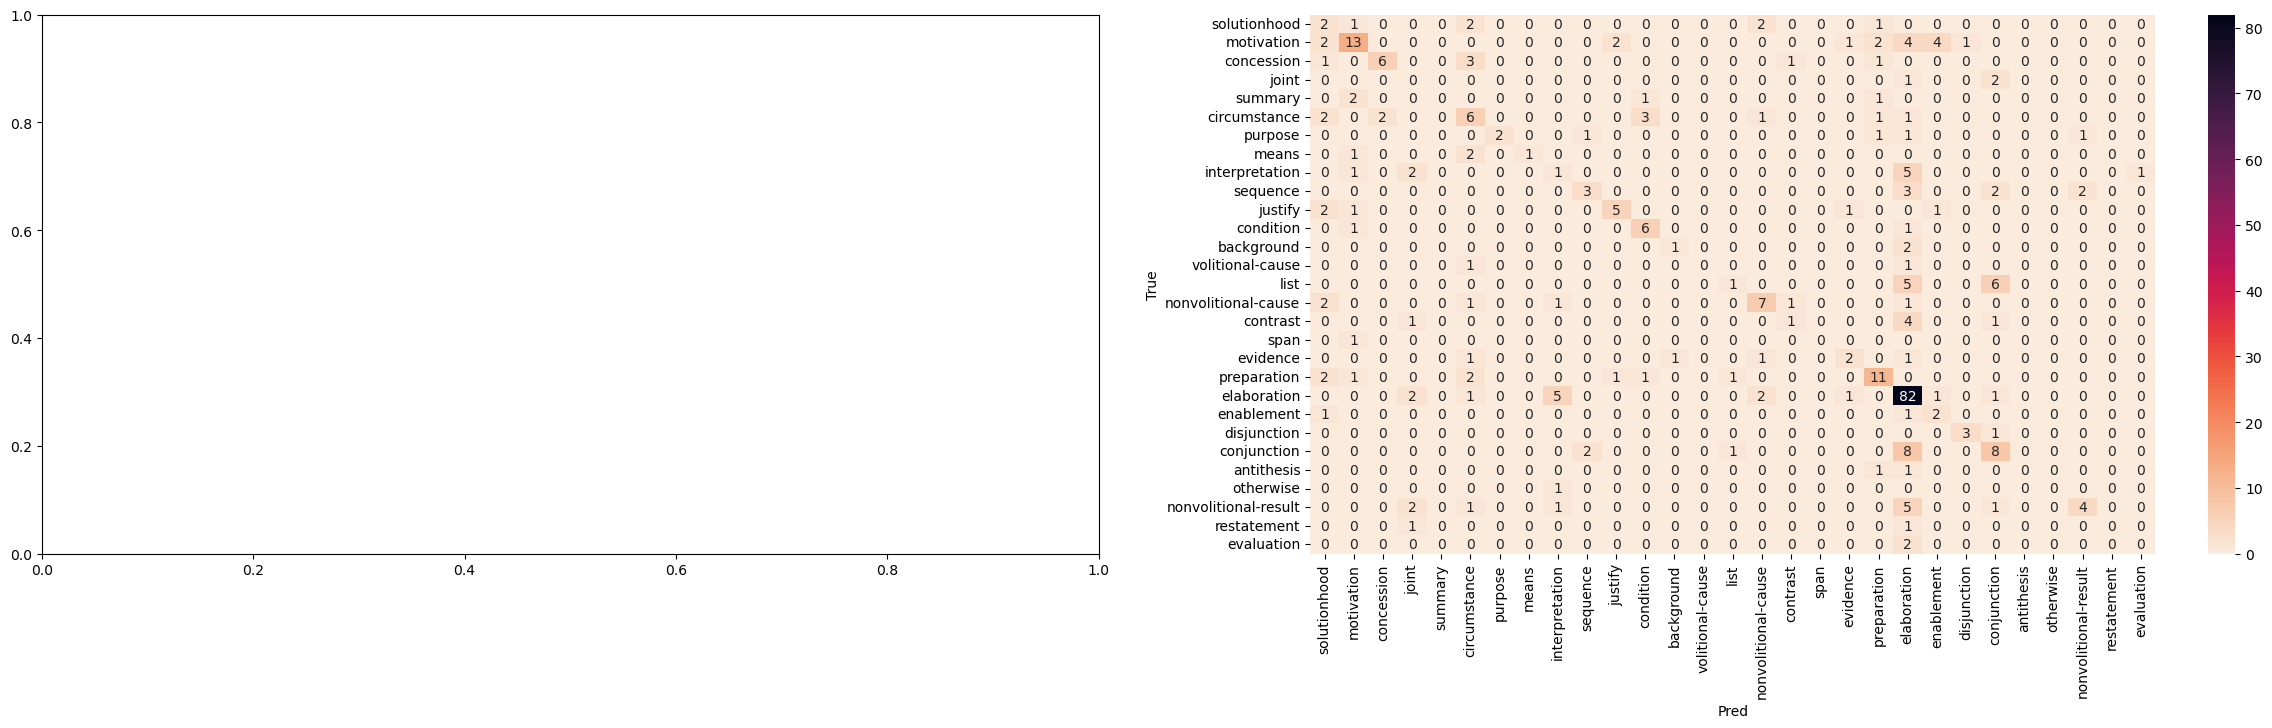

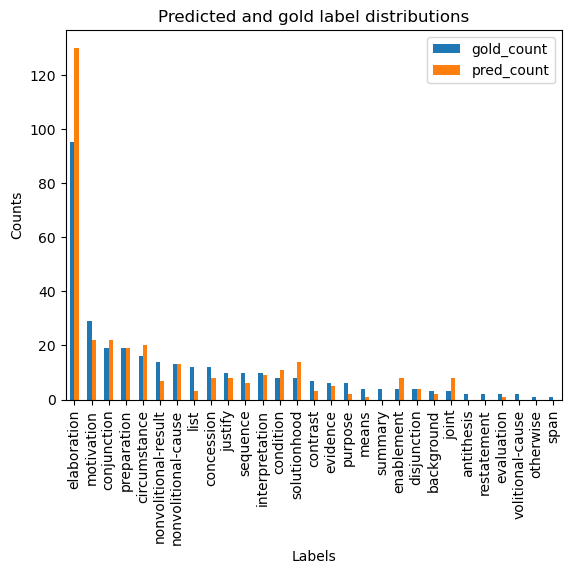

Test Loss: 1.600 |  Test Acc: 51.32%


In [58]:
from sklearn.metrics import confusion_matrix

def validate(model, test_loader, optimizer, rev_label_dict, label_dict, is_training=False):
  start = time.time()
  test_acc, test_loss, cr, model, optimizer, idx_json = evaluate_accuracy(model, optimizer, test_loader, rev_label_dict, label_dict, is_training=is_training)
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  print(cr)

  labels = list(set(idx_json['gold_label'])|set(idx_json['pred_label']))
  cm = confusion_matrix(idx_json['gold_label'], idx_json['pred_label'], labels=labels)

  fig, ax = plt.subplots(1, 2, figsize=(30, 7))
  ax[1] = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='.4g',cmap = sns.cm.rocket_r)
  ax[1].set_xlabel('Pred') 
  ax[1].set_ylabel('True')

  df_perf = pd.DataFrame()
  df_perf['gold_label'] = idx_json['gold_label']
  df_perf['pred_label'] = idx_json['pred_label']

  df_stats = pd.DataFrame()
  df_stats['gold_count'] = df_perf.groupby('gold_label').count()
  df_stats['pred_count'] = df_perf.groupby('pred_label').count()
  df_stats.fillna(0, inplace=True)
  df_stats.sort_values(by=["gold_count"], inplace=True, ascending=False)

  ax[0] = df_stats.plot.bar(rot=90, title="Predicted and gold label distributions")
  ax[0].set_xlabel("Labels")
  ax[0].set_ylabel("Counts")

  plt.show()

  return test_loss, test_acc, idx_json


test_loss, test_acc, idx_json = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_latest', test_loss, 1)
writer.add_scalar('test_acc_latest', test_acc, 1)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

### best earliest

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Unde

Test_loss: 1.2967 test_acc: 0.5102
00:00:00.71
                      precision    recall  f1-score   support

          antithesis       0.00      0.00      0.00         2
          background       0.00      0.00      0.00         3
        circumstance       0.35      0.50      0.41        16
          concession       0.80      0.67      0.73        12
           condition       0.43      0.75      0.55         8
         conjunction       0.38      0.42      0.40        19
            contrast       0.00      0.00      0.00         7
         disjunction       0.75      0.75      0.75         4
         elaboration       0.60      0.86      0.71        95
          enablement       0.00      0.00      0.00         4
          evaluation       0.00      0.00      0.00         2
            evidence       0.00      0.00      0.00         6
      interpretation       0.08      0.10      0.09        10
               joint       0.00      0.00      0.00         3
             justify  

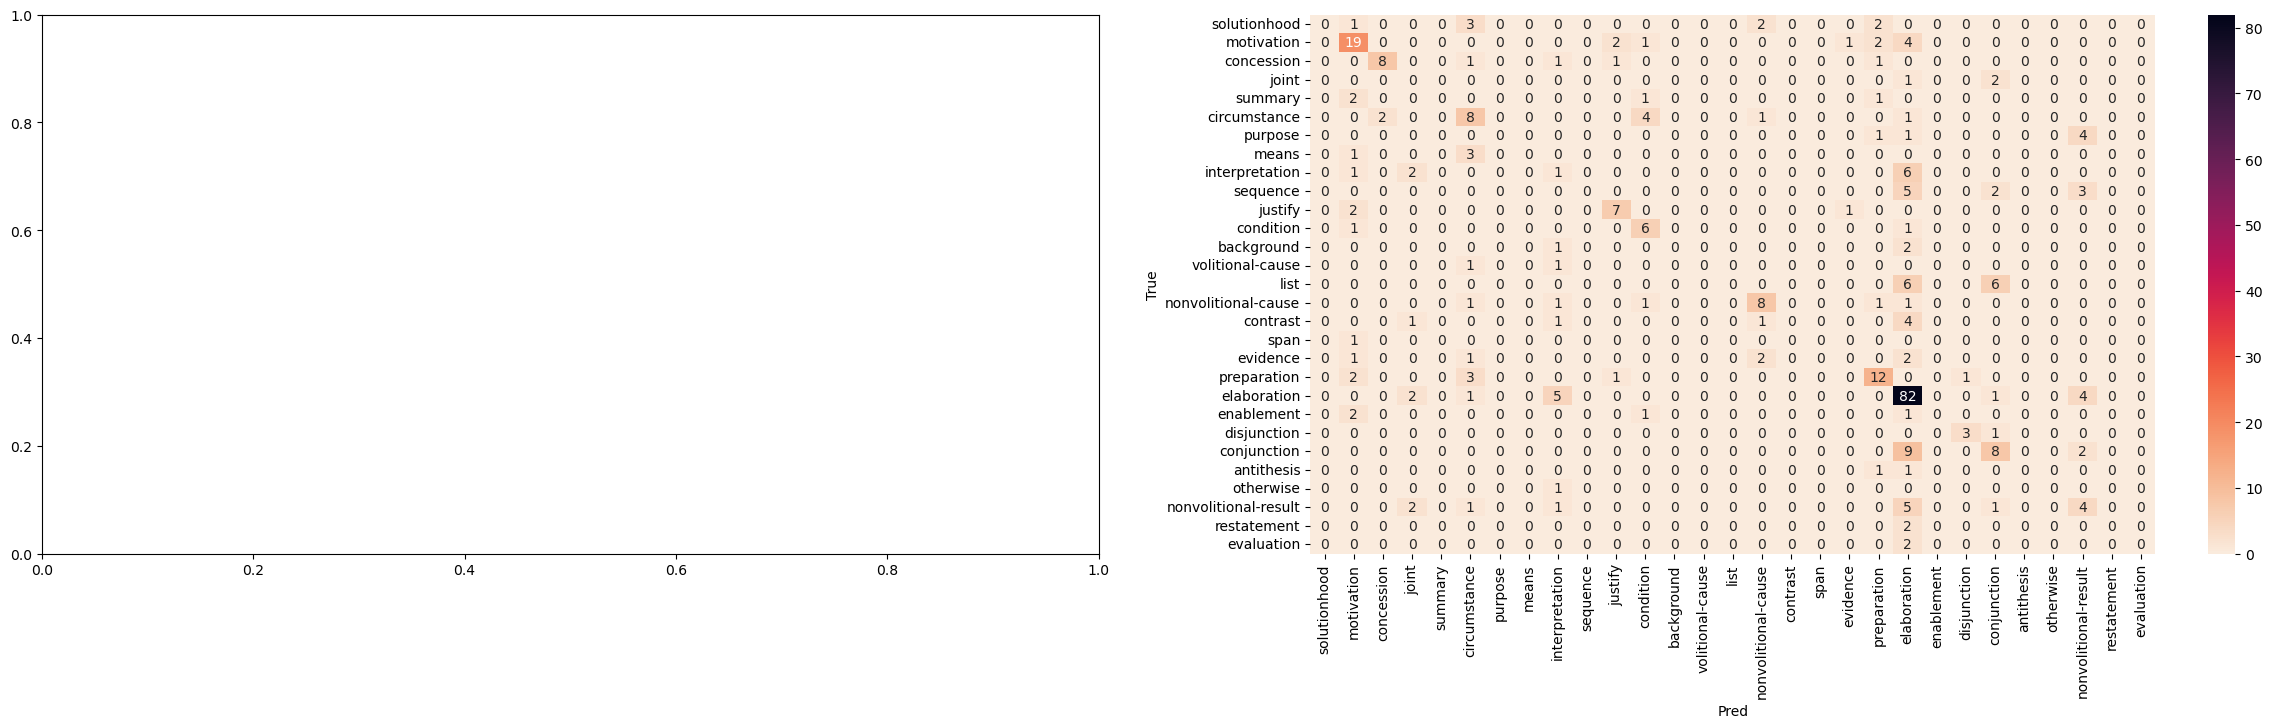

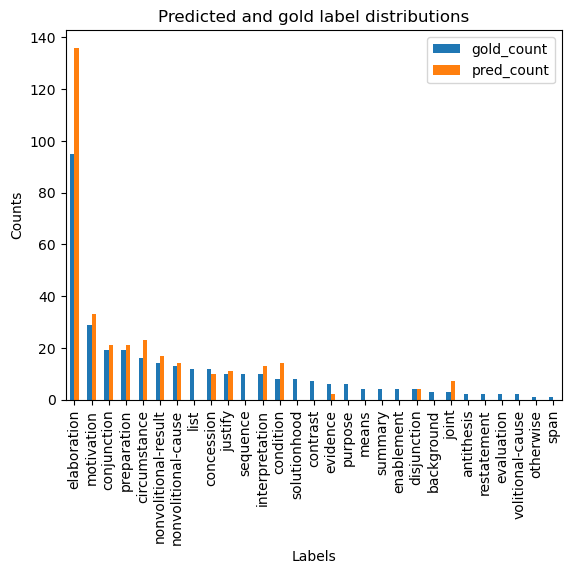

Latest Test Loss: 1.297 |  Latest Test Acc: 51.02%


In [59]:
model.load_state_dict(torch.load('run1/'+save_path_suffix+'_best.pt'))
test_loss, test_acc, idx_json = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_best_earliest', test_loss, 1)
writer.add_scalar('test_acc_best_earliest', test_acc, 1)
print(f'Latest Test Loss: {test_loss:.3f} |  Latest Test Acc: {test_acc*100:.2f}%')

### best lastest

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Unde

Test_loss: 1.2967 test_acc: 0.5102
00:00:00.70
                      precision    recall  f1-score   support

          antithesis       0.00      0.00      0.00         2
          background       0.00      0.00      0.00         3
        circumstance       0.35      0.50      0.41        16
          concession       0.80      0.67      0.73        12
           condition       0.43      0.75      0.55         8
         conjunction       0.38      0.42      0.40        19
            contrast       0.00      0.00      0.00         7
         disjunction       0.75      0.75      0.75         4
         elaboration       0.60      0.86      0.71        95
          enablement       0.00      0.00      0.00         4
          evaluation       0.00      0.00      0.00         2
            evidence       0.00      0.00      0.00         6
      interpretation       0.08      0.10      0.09        10
               joint       0.00      0.00      0.00         3
             justify  

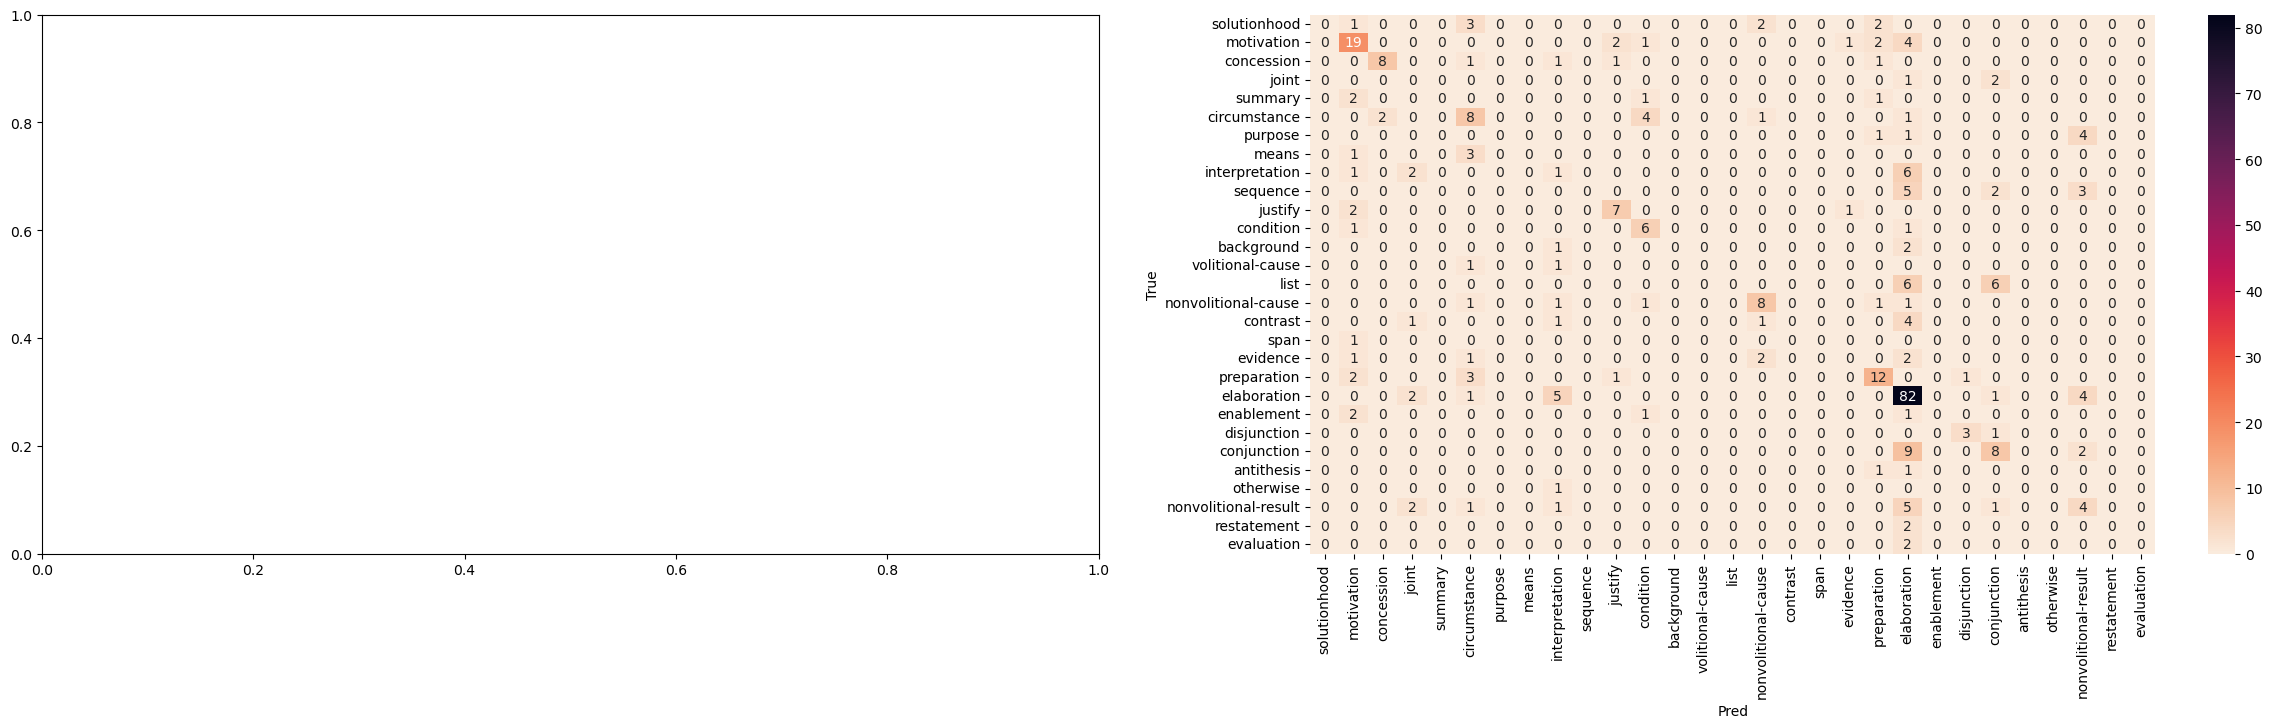

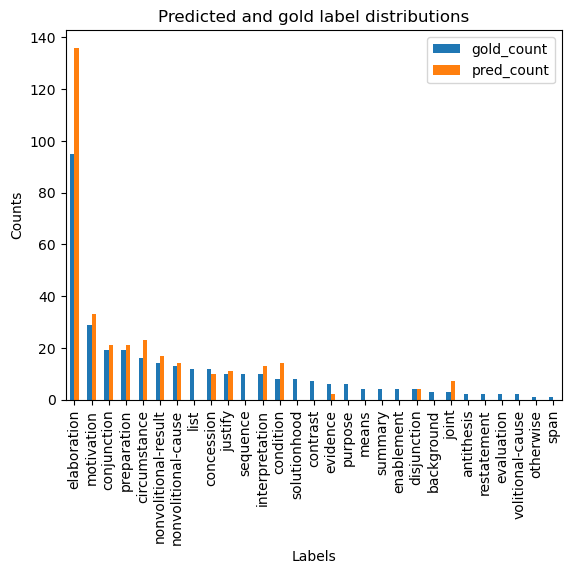

Best Test Loss: 1.297 |  Best Test Acc: 51.02%


In [60]:
model.load_state_dict(torch.load('run1/'+save_path_suffix+'_best_latest.pt'))
test_loss, test_acc, idx_json = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
json.dump(idx_json, open('run1/'+save_path_suffix+'_best_latest.json', 'w'))
writer.add_scalar('test_loss_best_latest', test_loss, 1)
writer.add_scalar('test_acc_best_latest', test_acc, 1)
print(f'Best Test Loss: {test_loss:.3f} |  Best Test Acc: {test_acc*100:.2f}%')

### best val

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Unde

Test_loss: 1.2780 test_acc: 0.5605
00:00:00.71
                      precision    recall  f1-score   support

          antithesis       0.00      0.00      0.00         5
          background       0.00      0.00      0.00         5
        circumstance       0.48      0.54      0.51        28
          concession       0.38      0.67      0.48         9
           condition       0.78      1.00      0.88         7
         conjunction       0.74      0.66      0.70        35
            contrast       0.00      0.00      0.00         4
         disjunction       0.40      0.20      0.27        10
         elaboration       0.67      0.83      0.74        92
          enablement       0.00      0.00      0.00         4
          evaluation       0.00      0.00      0.00         2
            evidence       0.00      0.00      0.00         6
      interpretation       0.22      0.40      0.29        10
               joint       0.15      0.22      0.18         9
             justify  

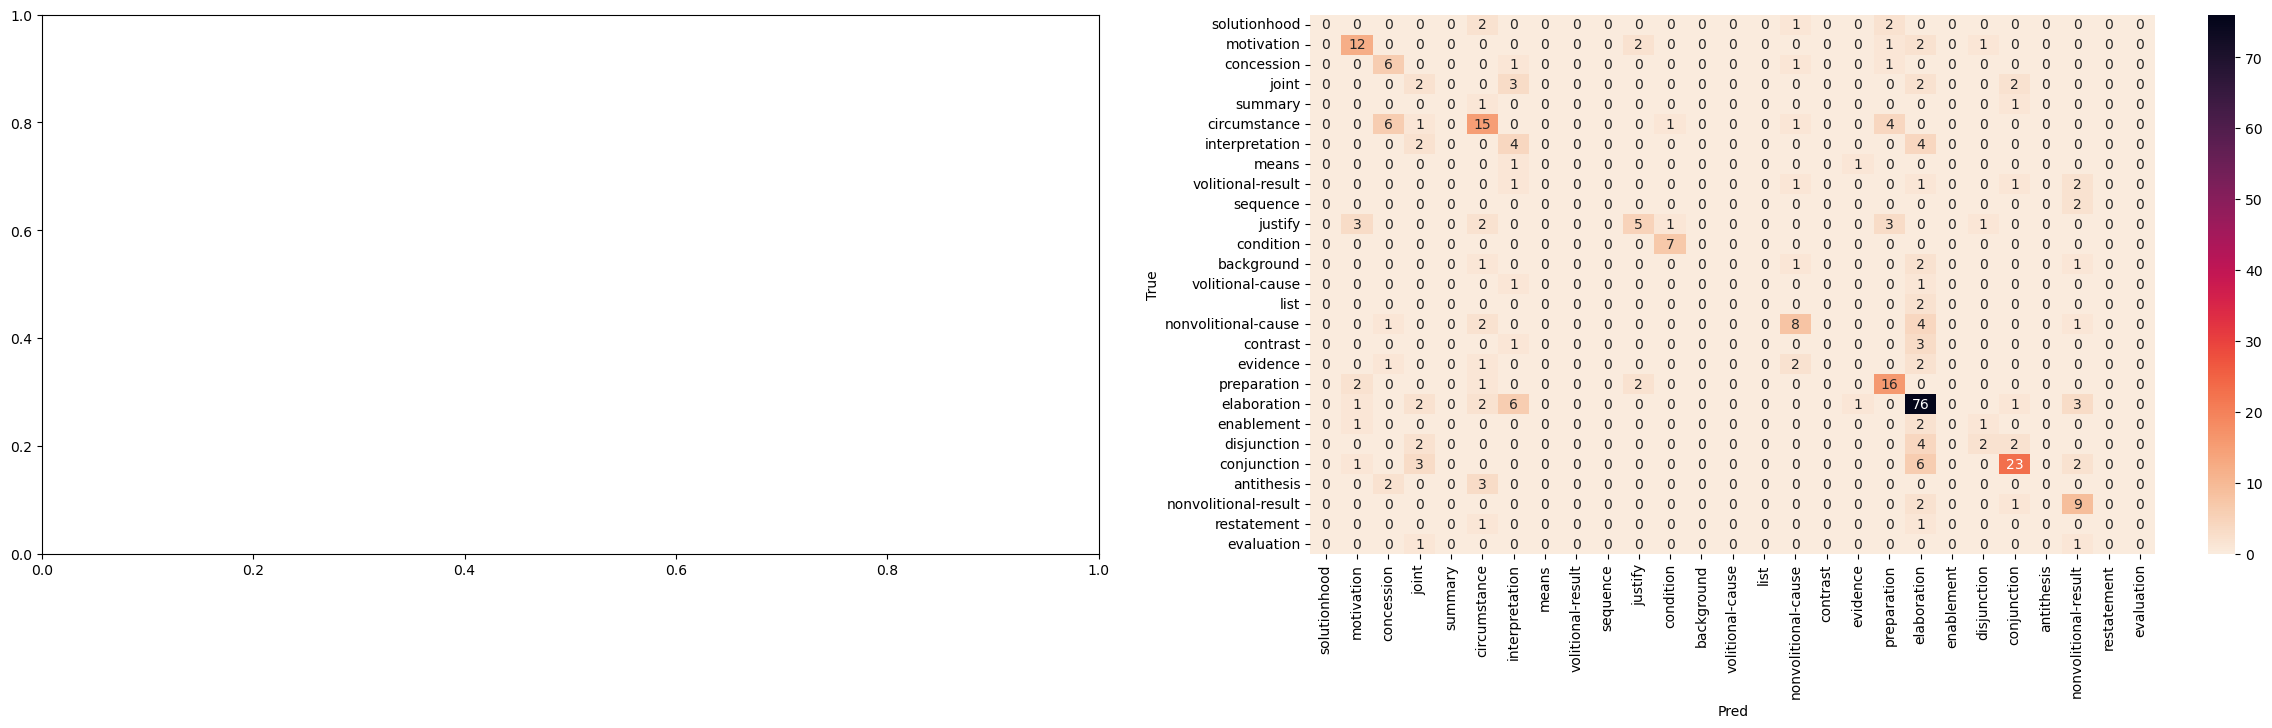

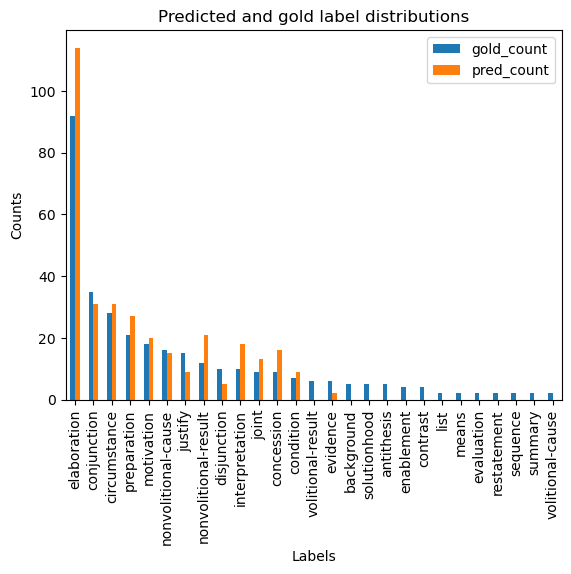

Val Loss: 1.278 |  Val Acc: 56.05%


In [61]:
model.load_state_dict(torch.load('run1/'+save_path_suffix+'_best_latest.pt'))
test_loss, test_acc, idx_json = validate(model, val_loader, optimizer, rev_label_dict, label_dict, is_training=True)
writer.add_scalar('val_loss_best_latest', test_loss, 1)
writer.add_scalar('val_acc_best_latest', test_acc, 1)
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')